# Self-Driving Car Engineer Nanodegree


## Project 5: **Vehicle Detection and Tracking** 
***
### The Goal of this Project
In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/udacity/CarND-Vehicle-Detection). There is an [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) in the repository provided as a starting point for your writeup of the project.


### The steps of this project are the following:

#### I - Extract Features
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

#### II - Build and Train a Classifier
* Train a classifier Linear SVM classifier.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

#### III - Conduct a Sliding Window Search
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

#### IV - Video Implementation
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
#### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Given Images
```
[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4
```

#![alt text][image2]

### I - Extract Features - Histogram of Oriented Gradients (HOG)
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

#### 1. Read the training images (vehicle and non-vehicle).

In [16]:
# Imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

Number of vehicle images:  8792
Number of non-vehicle images:  8968


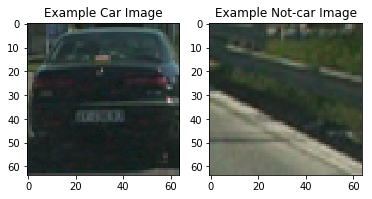

In [9]:
# Read in all the vehicles and non-vehicle images
# Randomly display one example for vehicle and non-vehicle images

path_v = 'project_datasets/vehicles/'
path_nv = 'project_datasets/non-vehicles/'

images_cars = os.listdir(path_v)
images_notcars = os.listdir(path_nv)

cars = []
notcars = []

for image_c in images_cars:
        cars.extend(glob.glob(path_v+image_c+'/*'))
        
for image_nc in images_notcars:
        notcars.extend(glob.glob(path_nv+image_nc+'/*'))
        
print('Number of vehicle images: ', len(cars)) 
print('Number of non-vehicle images: ', len(notcars)) 

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.title('Example Car Image')
plt.imshow(car_image)
plt.subplot(122)
plt.title('Example Not-car Image')
plt.imshow(notcar_image); #semi-colon to supress unwanted output


#### 2. Extract Histogram of Oriented Gradients (HOG) features from the labeled training set of images.

In [14]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm='L2-Hys')
        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    

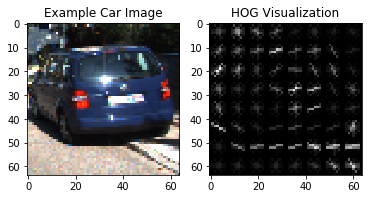

In [15]:
# Test get_hog_features()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');


#### Explore different color spaces and try various combinations of  `skimage.hog()` parameters
`orientations`, `pixels_per_cell`, and `cells_per_block`.  

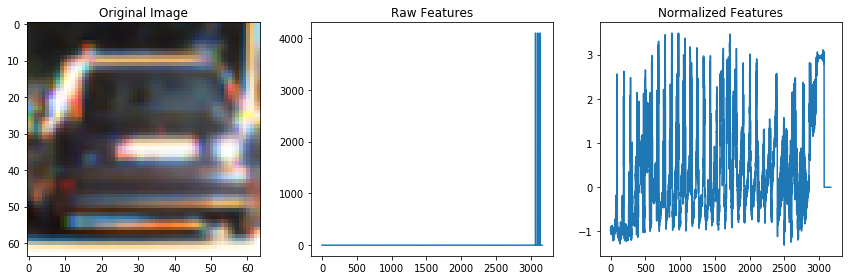

In [17]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

#### Example using the `YCrCb` color space and HOG parameters 
`orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`.

#### Final choice of HOG parameters.

### II - Build and Train a Classifier

#### 1. Train a classifier using the selected HOG features (and color features if used).

In [ ]:
# Train a linear SVM

### III -Sliding Window Search

#### 1. Implement a sliding window search.  
- Decide what scales to search?
- How much to overlap windows?
- How to optimize the performance of this classifier?

(Example: searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.)

In [ ]:
# Sliding Window Search

#### 2. Examples of test images to demonstrate how the pipeline is working.

In [ ]:
# Dispay test images to show how the pipeline is working

###  IV - Video Implementation

#### 1. Test pipeline on the entire project video.
(somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

#### 2. Implement some kind of filter for false positives and some method for combining overlapping bounding boxes.
- Record the positions of positive detections in each frame of the video. 
- From the positive detections create a heatmap.
- Thresholded that map to identify vehicle positions.
- Use `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.
- Assume each blob corresponded to a vehicle, construct bounding boxes to cover the area of each blob detected.
- Display result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video.

#### Here are six frames and their corresponding heatmaps:

#### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

#### 3. Here's a [link to my video result](./project_video_result.mp4).

### Discussion

#### Problems / issues aced in implementation of this project.  
- What approach and techniques were used?
- What worked and why?
- Where will the pipeline likely fail?  
- What could be further done to improve and make it more robust?